In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today

In [15]:
df_hourly = get_energy_data_today()

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df


---

In [26]:
# lead times are
horizons = [36, 40, 44, 60, 64, 68] #[24 + 12*i for i in range(5)]

def get_date_from_horizon(last_ts, horizon):
    
    """ adds horizon hours to timeindex last_ts """
    
    return last_ts + pd.DateOffset(hours = horizon)

LAST_IDX = -1
LAST_DATE = df_hourly.iloc[LAST_IDX].name
print(LAST_DATE)

thursday = LAST_DATE + pd.DateOffset(days=(3-LAST_DATE.weekday())%7)
thursday = thursday.replace(hour=0, minute=0, second=0, microsecond=0)
print(thursday)

horizon_date = [get_date_from_horizon(thursday, h) for h in horizons]
print(horizon_date)

2023-12-20 13:00:00+00:00
2023-12-21 00:00:00+00:00
[Timestamp('2023-12-22 12:00:00+0000', tz='UTC'), Timestamp('2023-12-22 16:00:00+0000', tz='UTC'), Timestamp('2023-12-22 20:00:00+0000', tz='UTC'), Timestamp('2023-12-23 12:00:00+0000', tz='UTC'), Timestamp('2023-12-23 16:00:00+0000', tz='UTC'), Timestamp('2023-12-23 20:00:00+0000', tz='UTC')]


In [44]:
# wanted to get closest weekday that is comparable in past year
# but in the worst case ... ie 21.2023
# the date in the past year with the same weekday is 22.2022 which is much closer to christmas

# - - - - - - - - - -

# # get past values of horizon dates from df_hourly dataframe

# past_yrs = np.arange(1,2)
# print(past_yrs)

# for past_yr in past_yrs : 

#     # shift horizon date by past_yr years back
#     old_horizon_date = [h - pd.DateOffset(years=past_yr) for h in horizon_date]
#     # also add all days between plus minus 7 days of old_horizon_date
#     old_horizon_date = old_horizon_date + [h + pd.DateOffset(days=d) for h in old_horizon_date for d in range(-7,8)]
#     # order dates
#     old_horizon_date.sort()

#     old_vals = df_hourly.loc[old_horizon_date]
#     print(old_vals.to_string())
    

[1]
                             gesamt             timestamp_CET  weekday
timestamp_UTC                                                         
2022-12-15 12:00:00+00:00  69676.00 2022-12-15 13:00:00+01:00        3
2022-12-15 16:00:00+00:00  70510.00 2022-12-15 17:00:00+01:00        3
2022-12-15 20:00:00+00:00  62225.00 2022-12-15 21:00:00+01:00        3
2022-12-16 12:00:00+00:00  67464.75 2022-12-16 13:00:00+01:00        4
2022-12-16 12:00:00+00:00  67464.75 2022-12-16 13:00:00+01:00        4
2022-12-16 16:00:00+00:00  68244.25 2022-12-16 17:00:00+01:00        4
2022-12-16 16:00:00+00:00  68244.25 2022-12-16 17:00:00+01:00        4
2022-12-16 20:00:00+00:00  58959.00 2022-12-16 21:00:00+01:00        4
2022-12-16 20:00:00+00:00  58959.00 2022-12-16 21:00:00+01:00        4
2022-12-17 12:00:00+00:00  59221.00 2022-12-17 13:00:00+01:00        5
2022-12-17 12:00:00+00:00  59221.00 2022-12-17 13:00:00+01:00        5
2022-12-17 16:00:00+00:00  62040.75 2022-12-17 17:00:00+01:00        5
20

In [31]:
tau = [.025, .25, .5, .75, .975]
last_t = 24*365*2

#rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

for i,d in enumerate(horizon_date):
    
    # Extract the weekday and hour from the date 'd'
    # (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) 
    weekday = d.weekday()
    hour = d.hour
    
    # Create a temporary DataFrame 'df_tmp' 
    # by selecting the first 'LAST_IDX' rows from the original DataFrame 'df'
    df_tmp = df_hourly.iloc[:LAST_IDX]
    
    # Define a condition 'cond' to filter rows in 'df_tmp' based on the weekday and time of day
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    # Calculate the quantiles of the 'gesamt' column in 'df_tmp' that meet the 'cond' condition
    # The quantiles are calculated for each 'tau' value, and the results are stored in 'pred_baseline'
    pred_baseline[i, :] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau)

pred_baseline = pred_baseline / 1000
pred_baseline

array([[50.19948125, 61.776625  , 64.917     , 68.8388125 , 73.33145   ],
       [52.16984375, 59.47725   , 62.232875  , 68.215375  , 73.9915    ],
       [46.02658125, 50.9810625 , 54.15225   , 60.2015    , 64.73714375],
       [46.48641875, 51.6725    , 53.555375  , 57.819     , 62.48138125],
       [47.20428125, 51.1768125 , 53.38225   , 59.3915    , 65.00858125],
       [42.08665   , 46.023375  , 48.626625  , 53.56975   , 57.6432625 ]])

Visually check if quantiles make sense

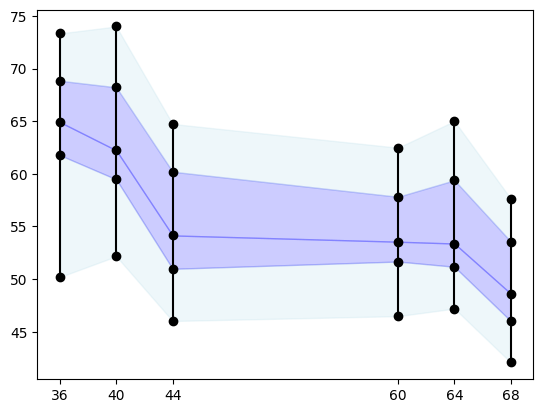

In [32]:
x = horizons
quantiles = tau
# tau = [.025, .25, .5, .75, .975]

colors = ['lightblue', 'blue', 'blue', 'lightblue']

# Creating colored intervals between quantiles
for i in range(len(quantiles) - 1):
    plt.fill_between(
        horizons,
        pred_baseline[:, i],
        pred_baseline[:, i + 1],
        alpha=0.2,  # Adjust transparency as needed
        color=colors[i],
        label=f'Quantile {quantiles[i]} - {quantiles[i + 1]}',
    )

_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [33]:
from datetime import datetime
date_str = datetime.today().strftime('%Y-%m-%d')

df_sub = pd.DataFrame({
    
    "forecast_date": date_str, 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]

})

df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-12-20,energy,36 hour,50.199481,61.776625,64.917000,68.838813,73.331450
1,2023-12-20,energy,40 hour,52.169844,59.477250,62.232875,68.215375,73.991500
2,2023-12-20,energy,44 hour,46.026581,50.981063,54.152250,60.201500,64.737144
3,2023-12-20,energy,60 hour,46.486419,51.672500,53.555375,57.819000,62.481381
4,2023-12-20,energy,64 hour,47.204281,51.176812,53.382250,59.391500,65.008581
5,2023-12-20,energy,68 hour,42.086650,46.023375,48.626625,53.569750,57.643262


In [34]:
for row_to_check in range(df_sub.shape[0]):
    row_values = df_sub.iloc[row_to_check, 3:].values
    is_ordered = all(row_values[i] <= row_values[i + 1] for i in range(len(row_values) - 1))
    print(is_ordered)

True
True
True
True
True
True


In [37]:
# need to change this
date_str = datetime.today().strftime('%Y_%m_%d')

PATH = "C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/Submissions"
df_sub.to_csv(PATH+"/"+date_str+"_power_benchmark.csv",index=False)